# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
import gpt

In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [5]:
path = Path('data/midi/midi_transcribe_v3_shortdur/')
path.ls()[:5]

[PosixPath('data/midi/midi_transcribe_v3_shortdur/ecomp'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/classic_piano'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/wikifonia'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/cprato'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/tmp_pop')]

In [6]:
model_path = 'tmp_clc_v3_gpt_5'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [7]:
bs=8
bptt=250

In [8]:
data = TextLMDataBunch.load(path, cache_name='tmp_clc', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t0 nG3 t4 nB3 t4 nD4 t4 nD5 t2 nG5 t4 || ',
 array([ 2,  9, 12, 16, ..., 23,  8, 14,  8]))

In [9]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

### Load Learner

In [10]:
config = gpt.OpenAIGPTConfig(vocab_size)
config.separate_embed = True
model = gpt.OpenAIGPTLMHeadModel(config).cuda()
model.reset = lambda: None

In [11]:
learn = LanguageLearner(data, model, bptt, clip=1)
learn.callbacks = []
# learn = language_model_learner(data, drop_mult=1, clip=.2, bptt=bptt)
learn = learn.load(model_path)

## Done

In [12]:
out = learn.pred_batch()

In [13]:
learn.show_results(rows=5, max_len=25)

text,target,pred
t1 || t1 nB3 t13 || t0 nC#4 t3 nE-4 t3 || t1 nC4 t1 || t1 nC#4 t3 nE-4 t1 || t0 nF3 t2,t1 nC#4 t2 nE-4 t1 || t0 nC4 t7 || t1 nC#4 t1 nE-4 t1 || t1 nB3 t13 || t1 nC#4 t1 nE-4 t1,t1 nC#4 t1 nE-4 t2 || t0 nC4 t1 || t0 nC#4 t1 nE-4 t1 || t0 nC#4 t1 || t0 nC#4 t1 nE-4 t1
|| t0 nE4 t2 || t0 nG4 t5 || t0 nE4 t2 nB-5 t37 || t1 nD4 t4 nF4 t1 nA4 t4 || t0 nE4,|| t0 nG4 t5 || t0 nE4 t4 nA5 t53 nC#6 t272 nE6 t58 || t0 nD4 t4 nA4 t6 nA6 t1 || t1 nF4,|| t0 nF4 t1 || t0 nE4 t1 || t1 || t1 || t1 || t0 nF4 t1 nF4 t4 || t1 || t0 nF4
nB5 t2 || t0 nC5 t6 nA5 t1 || t0 nB5 t4 || t0 nC6 t1 || t0 nE5 t15 nE6 t4 nC7 t4 ||,nD5 t1 nB5 t4 || t0 nA5 t2 || t1 nC5 t1 || t0 nD4 t1 || t0 nD5 t28 nD6 t4 nB6 t4 ||,nC6 t1 || t1 || t0 nC5 t1 || t0 nC5 t1 nA5 t0 nA5 t1 nB4 t0 nB4 t1 || t1 || t4 ||
nD1 t1 nE-2 t148 || t0 nA0 t2 nC1 t1 nD1 t2 nE2 t175 || t1 nA0 t1 nD1 t1 nE-3 t1 || t0 nB-1,nE3 t182 || t0 nA0 t1 || t0 nA0 t2 nB0 t6 nG#1 t14 nE-4 t3 || t1 nE-3 t1 nE4 t1 || t0 nE-4,|| t1 || t0 nA0 t1 || t0 nA0 t1 || t2 || t6 || t1 || t0 nA0 t1 || t1 || t0 nE-3
|| t0 nA1 t1 nB3 t1 || t1 nE2 t1 nE3 t1 || t1 nE3 t1 nB3 t1 || t0 nE2 t2 || t1 nA1,nE4 t1 || t0 nD4 t101 || t2 nG#1 t3 nA1 t3 nC#3 t4 || t0 nC#2 t1 || t1 nE2 t1 nE3 t1 ||,|| t2 || t0 nE2 t1 || t0 nE2 t2 nE4 t1 nB3 t3 nE3 t2 nE3 t1 || t1 nE2 t1 || t1 ||


In [68]:
idx = 20
# idx = 8
seed_len = 200
files = get_files(path/'classic_piano', recurse=True)
file = files[idx]; file

PosixPath('data/midi/midi_transcribe_v3_shortdur/classic_piano/chpn_op10_e01_format0.txt')

In [69]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); seed


'|| t0 nC2 t32 nC3 t1 || t1 nG3 t1 || t0 nC4 t1 || t0 nC3 t12 nE4 t1 || t0 nC4 t1 || t0 nG4 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG5 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nG6 t1 || t0 nC7 t1 || t0 nC3 t15 nE7 t1 || t0 nC7 t1 || t0 nG6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nG5 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG3 t1 || t1 nF1 t16 nF2 t16 || t0 nC3 t1 || t0 nA3 t1 || t0 nC4 t1 || t0 nF4 t1 || t0 nC4 t1 || t0 nA4 t1 || t0 nC5 t1 || t0 nF5 t1 || t0 nC5 t1 || t0 nA5 t1 || t0 nC6 t1 || t0 nF6 t1 || t0 nC6 t1 || t0 nA6 t1 || t0 nC7 t1 || t0 nF#1 t16 nF#2 t16 nE7 t1'

### Beam search

In [70]:
cuda_enabled=True
def get_x_input(partial):
    _, _, _, seq = partial
    max_len = bptt-50
    input = seq[-max_len:]
    input_var = torch.LongTensor([input])
    if cuda_enabled:
        input_var = input_var.cuda()
    return input_var
#     return input_var.unsqueeze(dim=0)

# song = string
# seq_length = generated song length
# beam_size = what to choose from
def beam_search(seed, seq_length, beam_size, learn):    
    xb, yb = learn.data.one_item(seed)
    seed_list = xb.squeeze().tolist()
    learn.model.reset()
    partial_sequences = [(0, 0, [], seed_list)]
    
    for i in progress_bar(range(seq_length), leave=False):
        partial_sequences = find_partials(partial_sequences, beam_size, learn)
    final_sequence = partial_sequences[0][3] # 0 = highest prob, 3 = seq
    return learn.data.vocab.textify(final_sequence), final_sequence
    
def find_partials(partial_sequences, beam_size, learn, 
                  no_maj:bool=False, no_unk:bool=True, temperature:float=2, 
                  min_p:float=None, random=True):
    partial_next = []
    for partial in partial_sequences:
        it, tot_p, p_list, seq = partial
        x_input = get_x_input(partial)
        y = torch.zeros_like(x_input)
        
        predict_probs = learn.pred_batch(batch=(x_input,y)).squeeze()[-1]
        if no_unk: predict_probs[learn.data.vocab.stoi[UNK]] = 0.
        if no_maj: predict_probs[learn.data.vocab.stoi[TK_MAJ]] = 0.
        if min_p is not None: predict_probs[res < min_p] = 0.
        if temperature != 1.: predict_probs.pow_(1 / temperature)
            
            
        if random:
            idxs = torch.multinomial(predict_probs, beam_size)
            probs = predict_probs[idxs]
        else:
            # last_it_probs = torch.exp(predict_probs[-(it+1):]) # this is to predict the last few iterations
            last_it_probs = torch.exp(predict_probs)
            probs, idxs = torch.topk(last_it_probs, beam_size, 0)
        
#         reps = [(data.vocab.itos[i],p) for i,p in zip(idxs,probs) if i in [8, 9]]
#         if reps: print(reps)
            
        def calc_prob(probs):
#             return np.prod(-np.log(probs[-beam_size:]))
            return -np.prod(np.abs(np.log(probs[-(beam_size*10):])))
            
        for prob,idx in zip(probs,idxs):
            new_p_list = p_list+[prob.item()]
#             print(calc_prob(new_p_list))
            partial_next.append((it+1, calc_prob(new_p_list), new_p_list, seq+[idx.item()]))

    partial_sequences = sorted(partial_next, key=lambda x: x[1], reverse=True)[:beam_size]
    return partial_sequences

In [71]:
pred_beam, idxs = beam_search(seed, seq_length=400, beam_size=4, learn=learn)

In [72]:
pred_beam

'|| t0 nC2 t32 nC3 t1 || t1 nG3 t1 || t0 nC4 t1 || t0 nC3 t12 nE4 t1 || t0 nC4 t1 || t0 nG4 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG5 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nG6 t1 || t0 nC7 t1 || t0 nC3 t15 nE7 t1 || t0 nC7 t1 || t0 nG6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nG5 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG3 t1 || t1 nF1 t16 nF2 t16 || t0 nC3 t1 || t0 nA3 t1 || t0 nC4 t1 || t0 nF4 t1 || t0 nC4 t1 || t0 nA4 t1 || t0 nC5 t1 || t0 nF5 t1 || t0 nC5 t1 || t0 nA5 t1 || t0 nC6 t1 || t0 nF6 t1 || t0 nC6 t1 || t0 nA6 t1 || t0 nC7 t1 || t0 nF#1 t16 nF#2 t16 nE7 t1 || t0 nA6 t1 || t0 nE6 t1 || t0 nG6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nG5 t1 || t0 nA5 t1 || t0 nE5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG3 t1 || t0 nC1 t16 nC2 t16 t1 || t0 nE3 t1 || t0 nG3 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG4 t1 || t0 nC5 t1 

In [73]:
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

'|| t0 nA6 t1 || t0 nE6 t1 || t0 nG6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nE6 t1 || t0 nG5 t1 || t0 nA5 t1 || t0 nE5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG3 t1 || t0 nC1 t16 nC2 t16 t1 || t0 nE3 t1 || t0 nG3 t1 || t0 nC4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG4 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nF5 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nC4 t1 nD4 t1 || t0 nE4 t1 || t0 nC4 t1 || t0 nG3 t1 || t0 nF3 t1 || t0 nG4 t1 || t0 nC5 t1 || t0 nG#4 t1 || t0 nG5 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nG4 t1 || t0 nC4 t1 nF4 t1 || t0 nE4 t1 || t0 nC4 t1 nF5 t1 || t0 nG4 t1 || t0 nE5 t1 || t0 nC5 t1 || t0 nG4 t1 || t0 nD5 t1 || t0 nG5 t1 || t0 nC5 t1 || t0 nE5 t1 || t0 nG5 t1 || t0 nE5 t1 || t0 nG5 t1 || t0 nD5 t1 || t0 nG5 t1 || t0 nD5 t1 || t0 nG5 t1 || t0 nC5 t1 || t0 nG5 t1 || t0 nE5 t1 || t0 nG5 t1 || t0 nE-5 t1 || t0 nF#6 t1 || t0 nG5 t1 || t0 nE6 t1 || t0 nC6 t1 || t0 nG6 t1 || t0 nE6 t1 || t0 nG6 t1 || t0 nF6 t1 |

In [74]:
ns = str2stream(seed)
ns.show('midi')

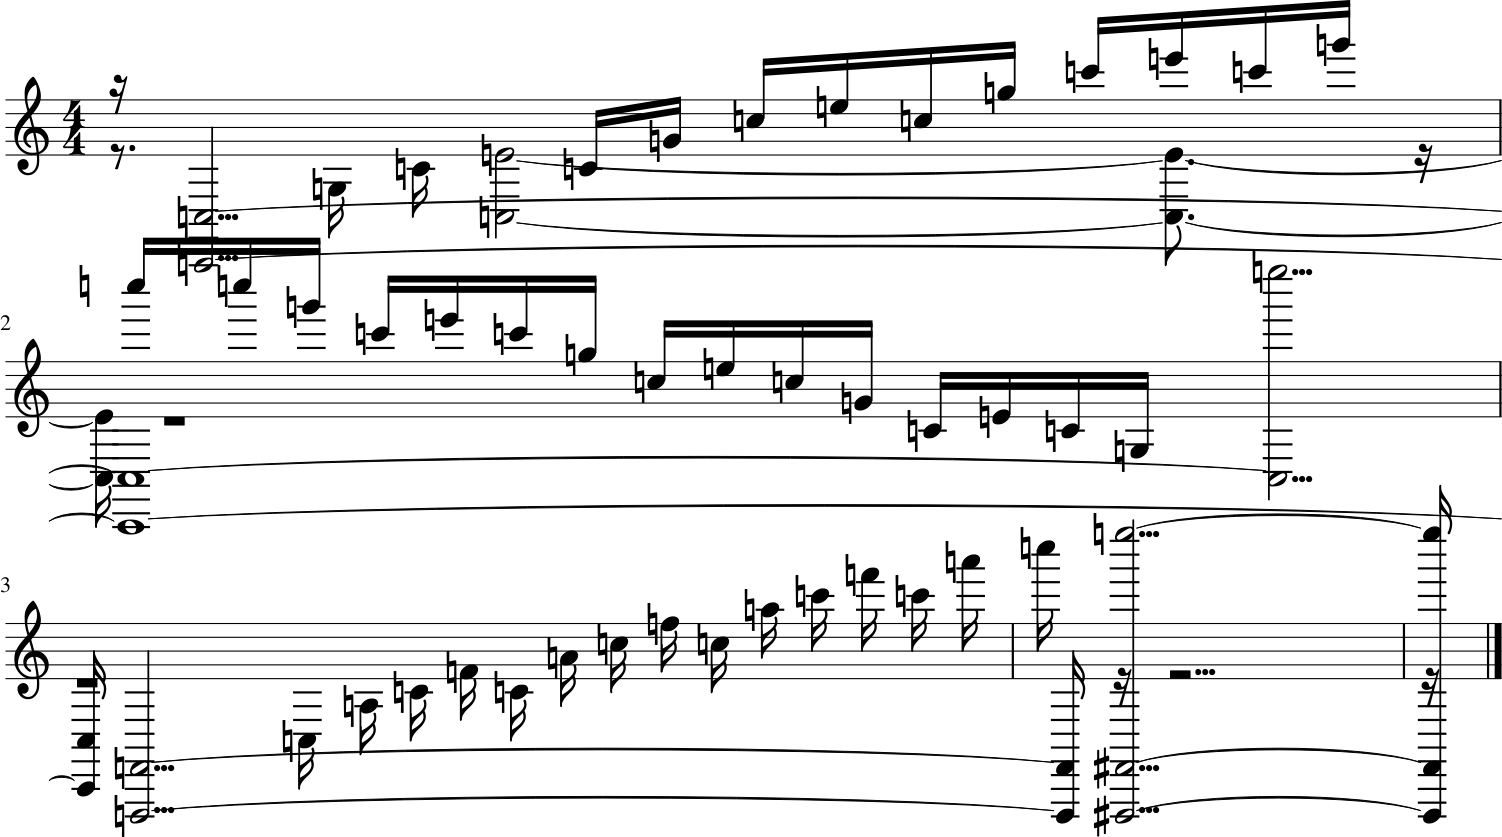

In [75]:
ns = str2stream(seed).show()

't'


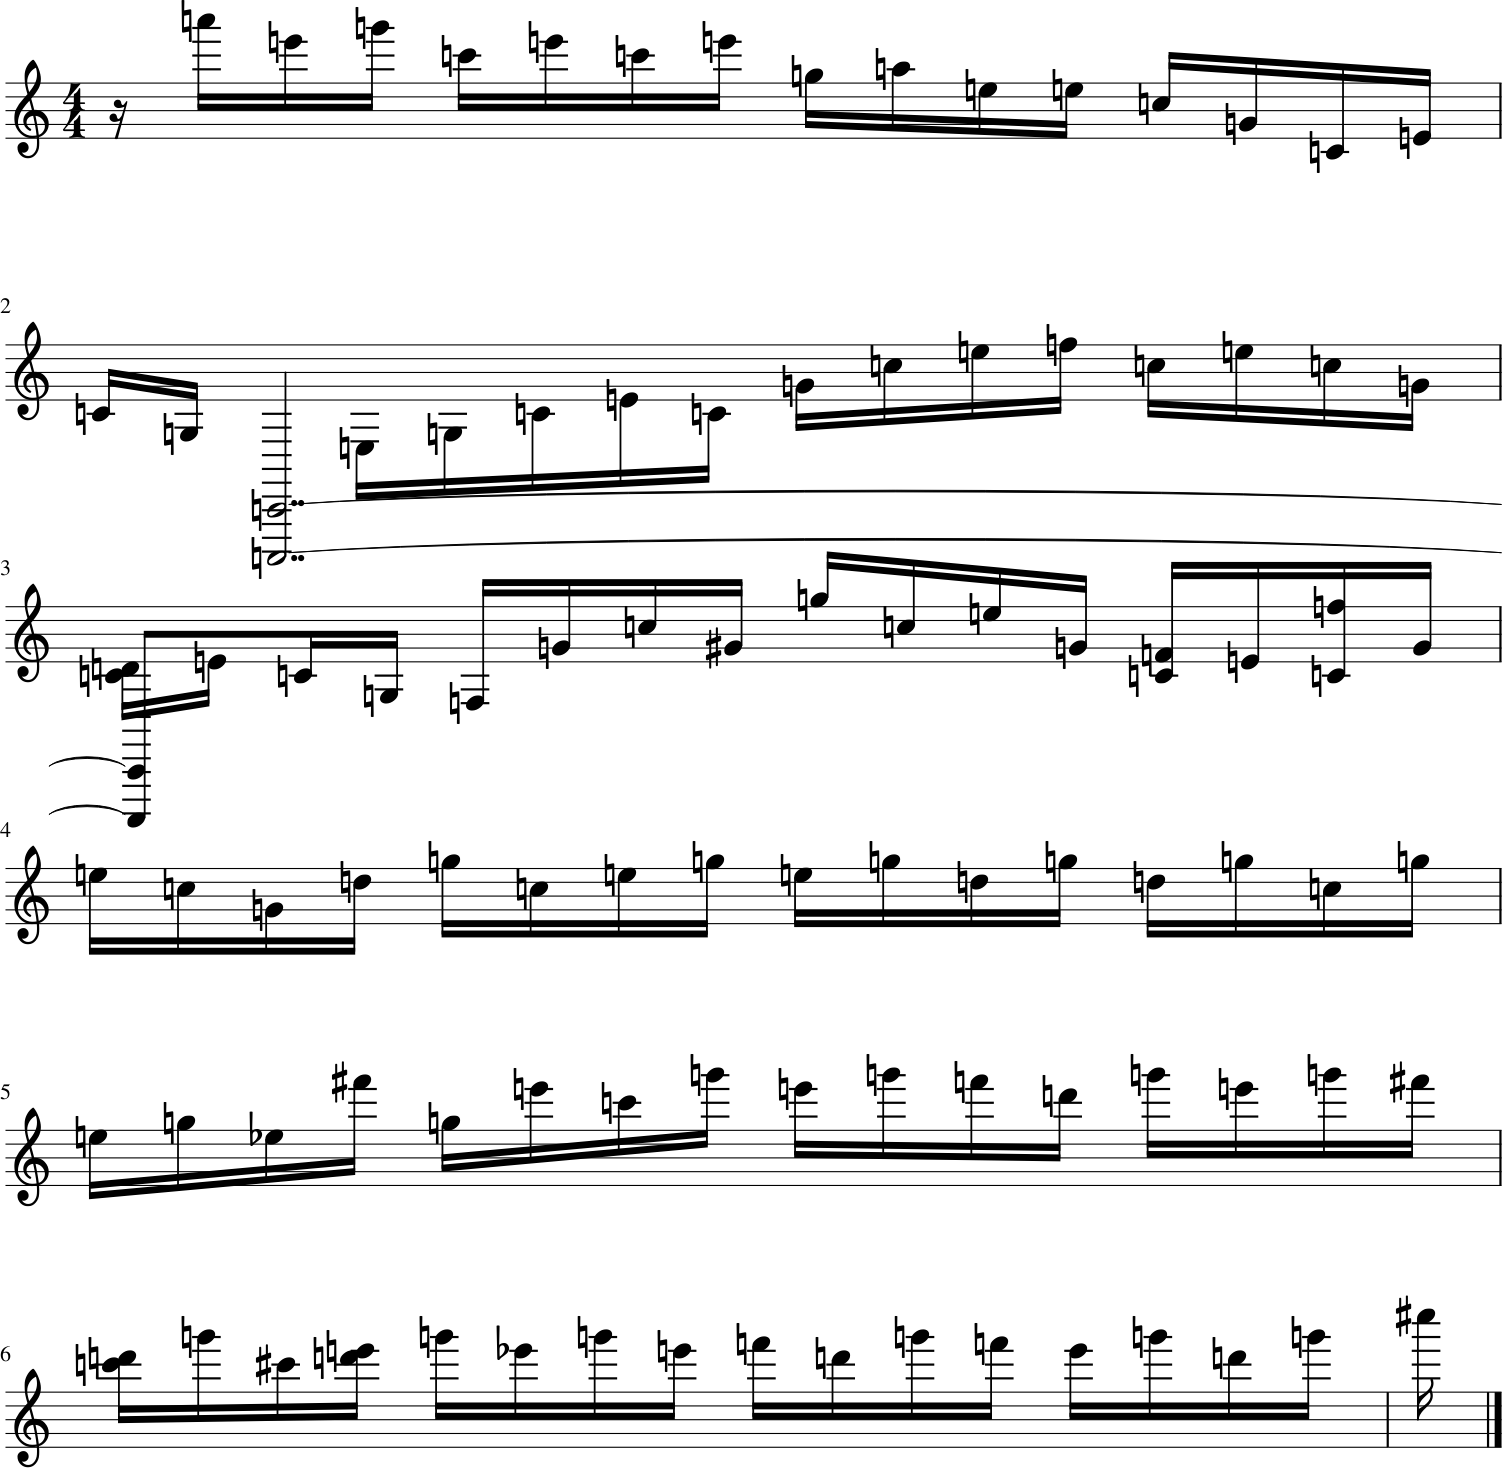

In [76]:
ns_only = str2stream(pred_beam_only).show()

In [77]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

't'


't'


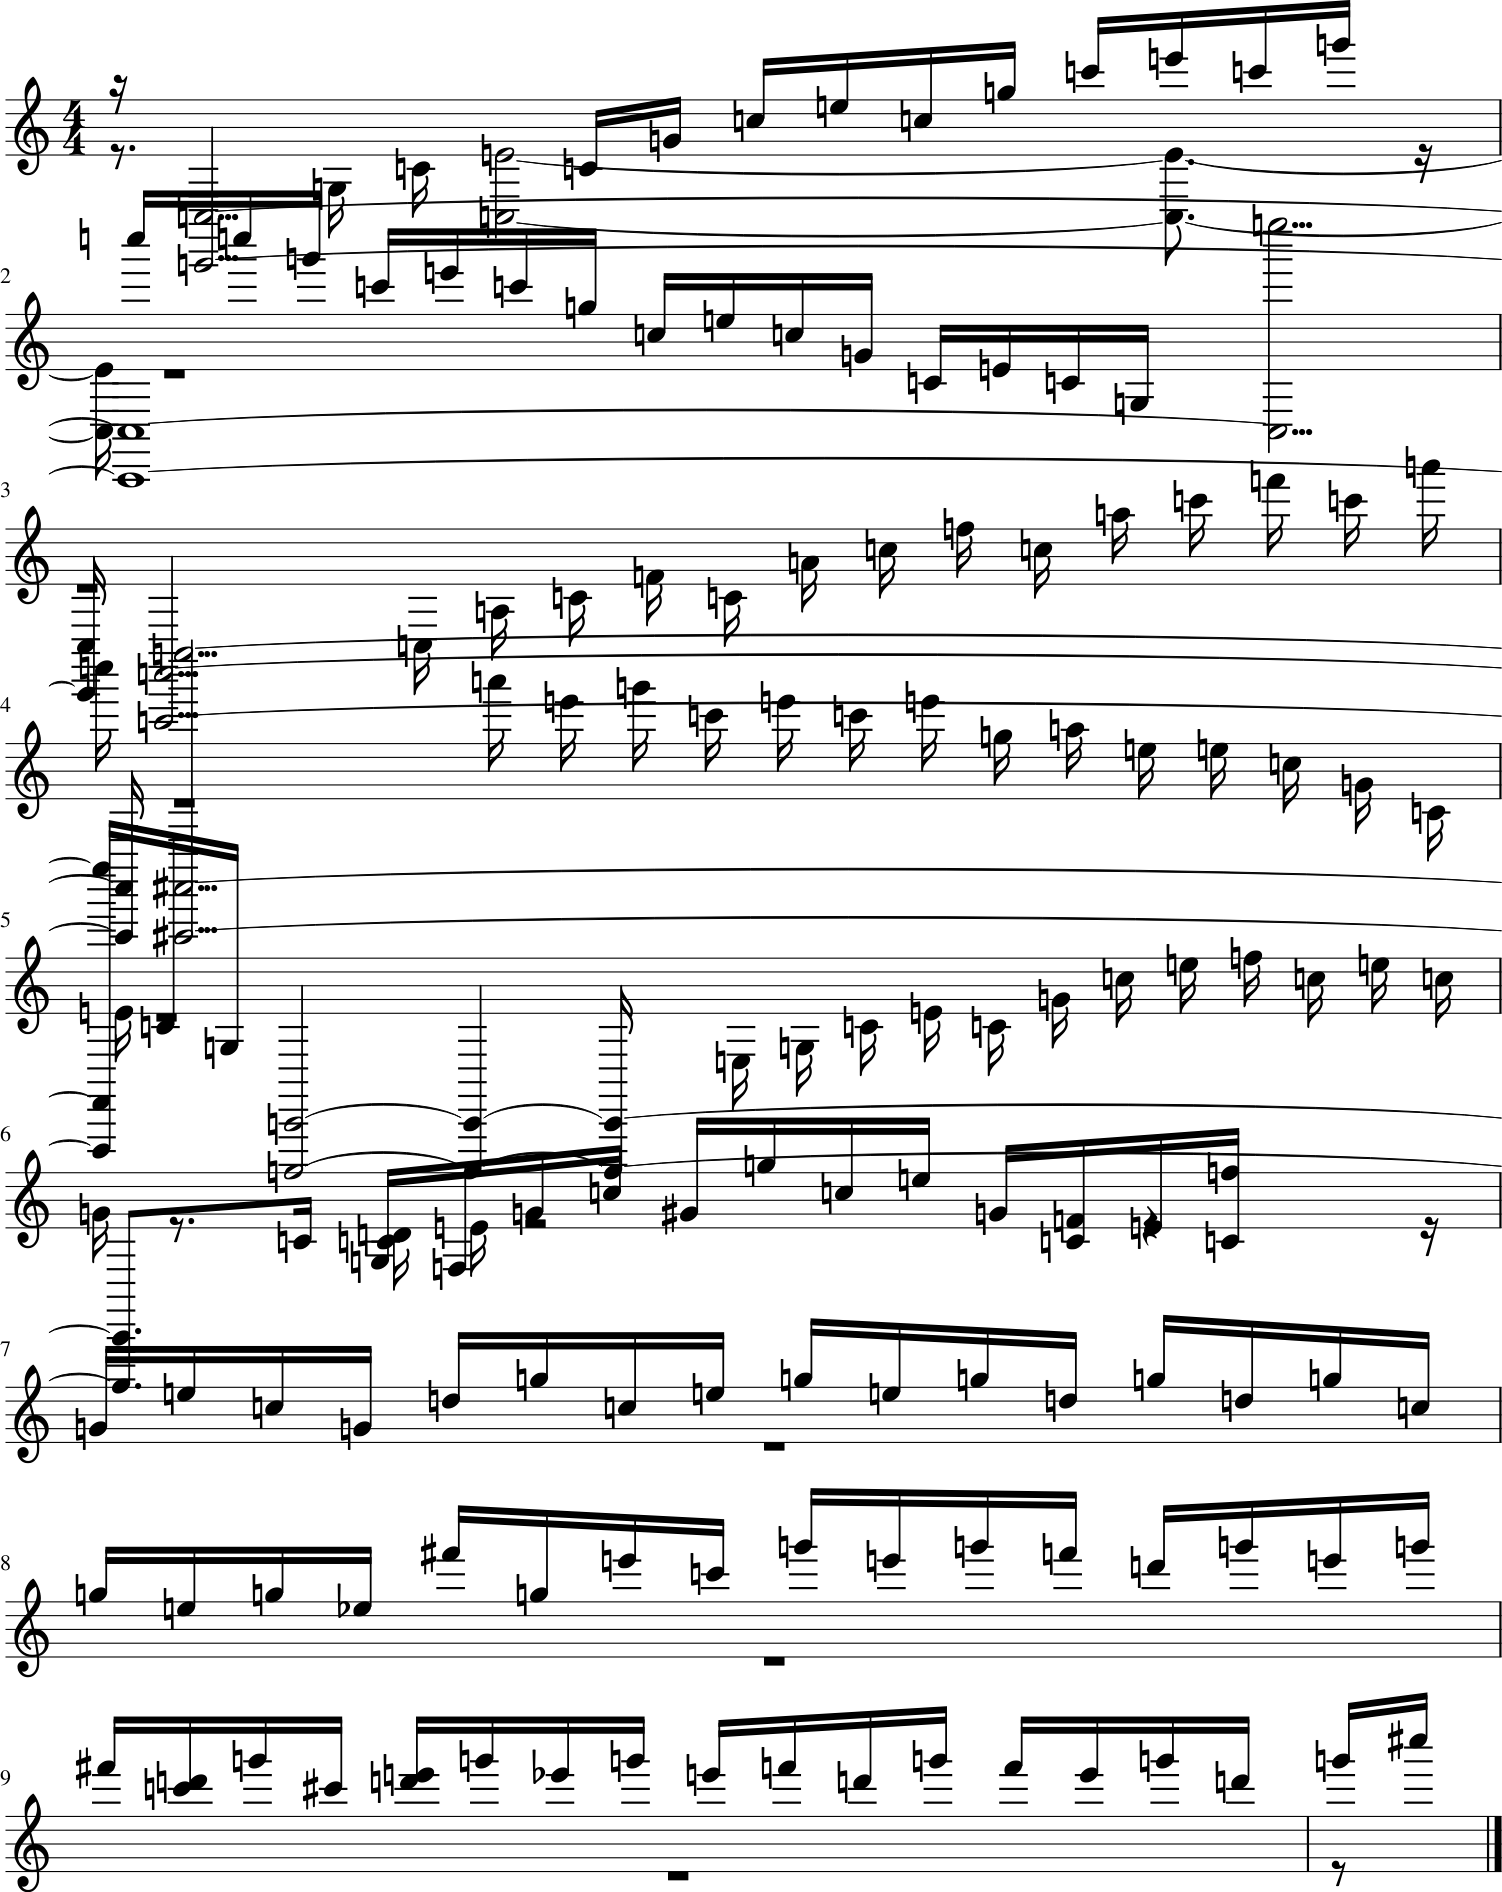

In [78]:
ns = str2stream(pred_beam).show()

In [79]:
ns = str2stream(pred_beam)
ns.show('midi')

't'


### Testing

In [16]:
# pred_out = learn.predict(seed, n_words=400); pred_out

In [25]:
seed

'|| t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nG#3 t4 nD4 t4 nE4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nG#3 t3 nD4 t3 nE4 t3 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 nG#3 t1 nD4 t1 nE4 t1 || t0 nE1 t1 nE2 t1 nA3 t8 nD4 t8 nF#4 t8 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nB3 t4 nD4 t4 nG#4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nB3 t3 nD4 t3 nG#4 t3 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 nB3 t1 nD4 t1 nG#4 t1 || t0 nE1 t1 nE2 t1 nC#4 t8 nE4 t8 nA4 t8 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nD4 t4 nG#4 t4 nB4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t

In [26]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

NameError: name 'pred_out' is not defined

### Generate from predictions

In [26]:
str2seq(pred_only)

't'


[[E2t1],
 [E1t1],
 [E1t1, E2t1, D4t5, E4t5],
 [E1t1, E2t1],
 [E1t1],
 [E1t1, E2t1],
 [E2t1, A3t4, C#4t4, F#4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [],
 [E1t1, E2t1],
 [],
 [E2t1, C#4t4, F4t4, G#4t4, B4t4],
 [],
 [],
 [E2t1],
 [E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1, C4t4, E4t4, A4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1, A3t4, C#4t4, F#4t4],
 [E1t1, E2t1],
 [E1t1],
 [E1t1, E2t1, B3t4, D4t4, G#4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1]]

In [27]:
note_stream = str2stream(pred_out)

't'


In [28]:
from midi_data import *

In [29]:
print_stream_durations(note_stream)

0.25 0.25 <music21.chord.Chord E1 E2>
0.25 0.5 <music21.chord.Chord E1 E2>
0.25 0.75 <music21.chord.Chord E1>
0.25 1.0 <music21.chord.Chord E1 E2>
0.25 1.25 <music21.chord.Chord E1 E2>
0.25 1.5 <music21.chord.Chord E1 E2>
0.25 1.75 <music21.chord.Chord E1>
0.25 2.0 <music21.chord.Chord E1 E2>
0.25 2.25 <music21.chord.Chord E1 E2 G#3 D4 E4>
0.25 2.5 <music21.chord.Chord E1 E2>
0.25 2.75 <music21.chord.Chord E1>
0.25 3.0 <music21.chord.Chord E1 E2>
0.25 3.25 <music21.chord.Chord E1 E2 G#3 D4 E4>
0.25 3.5 <music21.chord.Chord E1 E2>
0.25 3.75 <music21.chord.Chord E1>
0.25 4.0 <music21.chord.Chord E1 E2 G#3 D4 E4>
0.25 4.25 <music21.chord.Chord E1 E2 A3 D4 F#4>
0.25 4.5 <music21.chord.Chord E1 E2>
0.25 4.75 <music21.chord.Chord E1>
0.25 5.0 <music21.chord.Chord E1 E2>
0.25 5.25 <music21.chord.Chord E1 E2>
0.25 5.5 <music21.chord.Chord E1 E2>
0.25 5.75 <music21.chord.Chord E1>
0.25 6.0 <music21.chord.Chord E1 E2>
0.25 6.25 <music21.chord.Chord E1 E2 B3 D4 G#4>
0.25 6.5 <music21.chord.Chord 

In [30]:
note_stream.show('text')

{0.0} <music21.meter.TimeSignature 4/4>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120>
{0.0} <music21.key.KeySignature of no sharps or flats>
{0.0} <music21.stream.Part 0x7f9f14ae7710>
    {0.0} <music21.instrument.Piano Piano>
    {0.25} <music21.chord.Chord E1 E2>
    {0.5} <music21.chord.Chord E1 E2>
    {0.75} <music21.chord.Chord E1>
    {1.0} <music21.chord.Chord E1 E2>
    {1.25} <music21.chord.Chord E1 E2>
    {1.5} <music21.chord.Chord E1 E2>
    {1.75} <music21.chord.Chord E1>
    {2.0} <music21.chord.Chord E1 E2>
    {2.25} <music21.chord.Chord E1 E2 G#3 D4 E4>
    {2.5} <music21.chord.Chord E1 E2>
    {2.75} <music21.chord.Chord E1>
    {3.0} <music21.chord.Chord E1 E2>
    {3.25} <music21.chord.Chord E1 E2 G#3 D4 E4>
    {3.5} <music21.chord.Chord E1 E2>
    {3.75} <music21.chord.Chord E1>
    {4.0} <music21.chord.Chord E1 E2 G#3 D4 E4>
    {4.25} <music21.chord.Chord E1 E2 A3 D4 F#4>
    {4.5} <music21.chord.Chord E1 E2>
    {4.75} <music21.chord.Chord E1>
    {5

In [31]:
pred_format = pred_out.replace('xxbos ', '')

In [32]:
note_stream.show('midi')

In [39]:
Image(filename=str(note_stream.write('lily.png')))

LilyTranslateException: DurationException for durationObject <music21.duration.Duration 71.0>: Could not determine durationNumber from inexpressible